# Processo de Recuperação e Ranqueamento


## F1. Coleta e Indexação dos Documentos

### Coleta

In [ ]:
#baixar dados
!wget https://dadosabertos.camara.leg.br/arquivos/proposicoes/csv/proposicoes-2020.csv -O proposicoes-2020.csv -q 

# Ler documentos com Pandas
import pandas as pd

proposicoes = pd.read_csv("proposicoes-2020.csv", sep=";",encoding='utf-8', error_bad_lines=False)
proposicoes.head()

,id,uri,siglaTipo,numero,ano,codTipo,descricaoTipo,ementa,ementaDetalhada,keywords,dataApresentacao,uriOrgaoNumerador,uriPropAnterior,uriPropPrincipal,uriPropPosterior,urlInteiroTeor,urnFinal,ultimoStatus_dataHora,ultimoStatus_sequencia,ultimoStatus_uriRelator,ultimoStatus_idOrgao,ultimoStatus_siglaOrgao,ultimoStatus_uriOrgao,ultimoStatus_regime,ultimoStatus_descricaoTramitacao,ultimoStatus_idTipoTramitacao,ultimoStatus_descricaoSituacao,ultimoStatus_idSituacao,ultimoStatus_despacho,ultimoStatus_url
0,2077498,https://dadosabertos.camara.leg.br/api/v2/prop...,PL,1600,2020,139,Projeto de Lei,"Altera a Lei nº 8.069, de 13 de julho de 1990,...",NaN,"Alteração, Estatuto da Criança e do Adolescent...",2016-02-18T12:56:57,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,http://legis.senado.leg.br/dadosabertos/materi...,http://www.camara.gov.br/proposicoesWeb/prop_m...,NaN,2020-04-06T18:44:00,60,https://dadosabertos.camara.leg.br/api/v2/depu...,100229.0,SEPRO,https://dadosabertos.camara.leg.br/api/v2/orga...,"Ordinária (Art. 151, III, RICD)",Apresentação de Proposição,100,Aguardando Recebimento,917.0,Apresentação da Emenda/Substitutivo do Senado ...,http://www.camara.gov.br/proposicoesWeb/prop_m...
1,2116186,https://dadosabertos.camara.leg.br/api/v2/prop...,PL,1599,2020,139,Projeto de Lei,Institui a Semana Nacional de Prevenção e Comb...,NaN,"Criação, Semana Nacional de Prevenção e Combat...",2016-11-07T18:01:00,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,http://legis.senado.leg.br/dadosabertos/materi...,http://www.camara.gov.br/proposicoesWeb/prop_m...,NaN,2020-04-06T18:17:00,64,https://dadosabertos.camara.leg.br/api/v2/depu...,100229.0,SEPRO,https://dadosabertos.camara.leg.br/api/v2/orga...,"Ordinária (Art. 151, III, RICD)",Apresentação de Proposição,100,Aguardando Recebimento,917.0,Apresentação da Emenda/Substitutivo do Senado ...,http://www.camara.gov.br/proposicoesWeb/prop_m...
2,2236217,https://dadosabertos.camara.leg.br/api/v2/prop...,SUG,1,2020,285,Sugestão,Sugere estudo visando verificar a atuação do M...,NaN,NaN,2020-01-03T11:09:00,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,NaN,http://www.camara.gov.br/proposicoesWeb/prop_m...,NaN,2020-01-03T11:09:00,1,NaN,5438.0,CLP,https://dadosabertos.camara.leg.br/api/v2/orga...,"Ordinária (Art. 151, III, RICD)",Apresentação de Proposição,100,Aguardando Designação de Relator,907.0,"Apresentação da Sugestão n. 1/2020, pelo Socie...",http://www.camara.gov.br/proposicoesWeb/prop_m...
3,2236218,https://dadosabertos.camara.leg.br/api/v2/prop...,SUG,2,2020,285,Sugestão,Sugere audiência pública para debater assuntos...,NaN,NaN,2020-01-03T11:24:00,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,NaN,http://www.camara.gov.br/proposicoesWeb/prop_m...,NaN,2020-01-03T11:24:00,1,NaN,5438.0,CLP,https://dadosabertos.camara.leg.br/api/v2/orga...,"Ordinária (Art. 151, III, RICD)",Apresentação de Proposição,100,Aguardando Designação de Relator,907.0,"Apresentação da Sugestão n. 2/2020, pela Socie...",http://www.camara.gov.br/proposicoesWeb/prop_m...
4,2236222,https://dadosabertos.camara.leg.br/api/v2/prop...,RIC,1,2020,148,Requerimento de Informação,Requer informações detalhadas ao Ministro da C...,NaN,NaN,2020-01-03T14:50:13,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,NaN,http://www.camara.gov.br/proposicoesWeb/prop_m...,NaN,2020-03-18T00:00:00,22,https://dadosabertos.camara.leg.br/api/v2/depu...,5470.0,1SECM,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,Providência Interna - Comunicação de resposta ...,1056,Aguardando Remessa ao Arquivo,931.0,Encaminhamento de resposta por meio do sistema...,NaN


### Servidor ES

In [ ]:
# Instalar servidor ES

#Instalar Java
!apt install default-jdk > /dev/null

#Donwload ES
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.8.0-linux-x86_64.tar.gz -q --show-progress

#Descompacta
!tar -xzf elasticsearch-7.8.0-linux-x86_64.tar.gz

#Atribui permissão ao usuario "daemon"
!chown -R daemon:daemon elasticsearch-7.8.0

# Iniciar o servidor
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.8.0/bin/elasticsearch'],stdout=PIPE, stderr=STDOUT,preexec_fn=lambda: os.setuid(1))  
# as daemon)

# Instalar module python
!pip install elasticsearch -q
!pip install elasticsearch-dsl -q

import time
time.sleep(5)



elasticsearch-7.8.0 100%[===================>] 304.33M  76.1MB/s    in 4.4s    
     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 61kB 2.5MB/s 


In [ ]:
from elasticsearch import Elasticsearch

es = Elasticsearch()
if es.ping():
  print("ElasticSearch ONLINE !")

ElasticSearch ONLINE !


### Indexação no ES

#### Criar Índice

In [ ]:
# Utilizando Elasticsearch-dsl
from elasticsearch_dsl import Index
from elasticsearch_dsl.connections import connections

# Define a default Elasticsearch client
connections.create_connection()

index_name = 'politica-index'
politica = Index(index_name)


politica.settings(
    number_of_shards=1,
    number_of_replicas=0,
    similarity = {
              "minha_similarity" : {
                "type" : "DFR",
                "basic_model" : "g",
                "after_effect" : "l",
                "normalization" : "h2",
                "normalization.h2.c" : "3.0"
              }
            }
)

if not politica.exists():
  politica.create()
else:
  politica.delete()
  politica.create()


politica.get()

{'politica-index': {'aliases': {},
  'mappings': {},
  'settings': {'index': {'creation_date': '1594562573949',
    'number_of_replicas': '0',
    'number_of_shards': '1',
    'provided_name': 'politica-index',
    'similarity': {'minha_similarity': {'after_effect': 'l',
      'basic_model': 'g',
      'normalization': 'h2',
      'normalization.h2': {'c': '3.0'},
      'type': 'DFR'}},
    'uuid': 'CEOAYj4GTJSLgEFme1SQsw',
    'version': {'created': '7080099'}}}}}

#### Análise dos documentos

In [ ]:
# Três passos da análise
from elasticsearch_dsl.analysis import analyzer, char_filter, tokenizer, token_filter

# ANALISADOR em PORTUGUES BRASIL

#Char filter
char_filter_ptbr = char_filter('html_strip')

#Tokenizador
tokenizador_ptbr = tokenizer('standard')

#Token Filter
pt_stop_filter = token_filter('brazilian_stop', type='stop', stopwords='_brazilian_')
pt_stem_filter = token_filter('brazilian_stemmer', type='stemmer', language='brazilian')

#Analisador
pt_analyzer = analyzer(
    'pt_analyzer',
    tokenizer = tokenizador_ptbr,
    filter = ["lowercase", pt_stop_filter, pt_stem_filter],
    char_filter = [char_filter_ptbr]
)

#### Mapeamento



https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html

In [ ]:
# Criar a entidade
from elasticsearch_dsl import Document, Text, Date, Keyword

class Projeto(Document):
  ementa = Text(analyzer = pt_analyzer, similarity='BM25')
  topicos = Text(similarity='minha_similarity')
  data = Date()  
  tipo = Keyword()

# Mapear no index
politica.document(Projeto)
politica.close()
Projeto.init()
politica.open()

#Visualizar Mappeamento
politica.get_mapping()

{'politica-index': {'mappings': {'properties': {'data': {'type': 'date'},
    'ementa': {'analyzer': 'pt_analyzer',
     'similarity': 'BM25',
     'type': 'text'},
    'tipo': {'type': 'keyword'},
    'topicos': {'similarity': 'minha_similarity', 'type': 'text'}}}}}

#### Carregar documentos

In [ ]:
#Usando Bulk
from elasticsearch.helpers import bulk
from random import randrange

proposicoes = proposicoes.fillna('')

projetos = []
for p in proposicoes.itertuples(index=False):
  projeto = Projeto(meta = {'id': p.id})

  projeto.tipo = p.siglaTipo
  projeto.ementa = p.ementa
  projeto.data = p.dataApresentacao
  projeto.topicos = p.keywords
  projeto.clicks = randrange(10)

  projetos.append(projeto)

bulk(client=politica.connection, actions=(p.to_dict(include_meta=True) for p in projetos),index=politica._name)


(20024, [])

In [ ]:
#Funções Uteis para imprimir

import json
import pandas as pd
from IPython.display import display

def jprint(dicionario):
    print(json.dumps(dicionario, indent=2, ensure_ascii=False))

def eprint(response):
  results = []
  for doc in response.hits:
    r = doc.to_dict()
    r['id'] = doc.meta.id
    r['score'] = doc.meta.score
    results.append(r)
  display(pd.DataFrame.from_records(results))

## F2. Recuperação e Ranqueamento

### Buscas

In [ ]:
from elasticsearch_dsl import Search

s = Search()

#### Buscas Básicas



##### 1. Consulta full-text




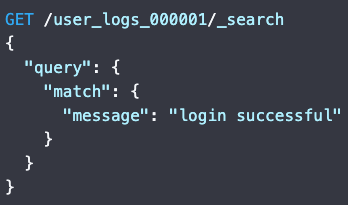

In [ ]:
s = Search(index="politica-*")
s = s.query("match",ementa="saneamento básico")

jprint(s.to_dict())

{
  "query": {
    "match": {
      "ementa": "saneamento básico"
    }
  }
}


In [ ]:
response = s.execute()
eprint(response)

In [ ]:
s = Search(index="politica-*")
s = s.query("match",ementa="saneamento básico")
s = s.extra(explain=True)

jprint(s.execute().to_dict())

Consulta em múltiplos campos

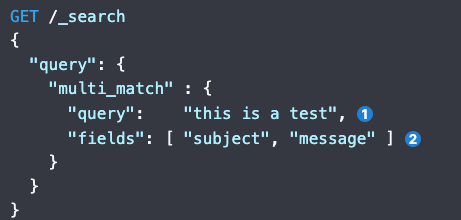

Consulta com frases

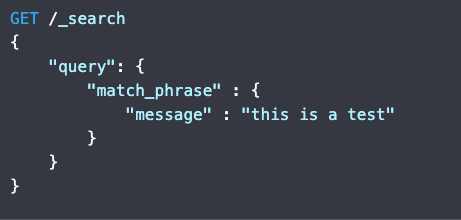




##### 2. Consultas por múltiplos termos



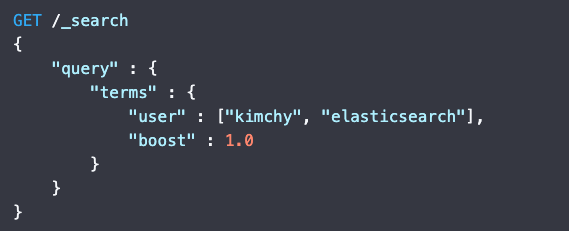


##### 3. Consultas Booleanas (query_string)



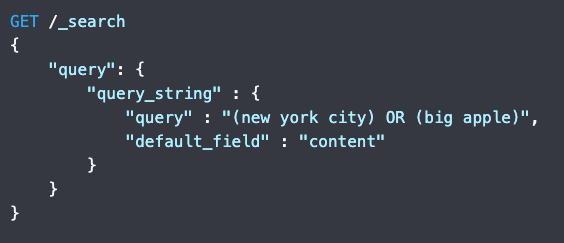


##### 4. Consultas utilizando lógica Fuzzy



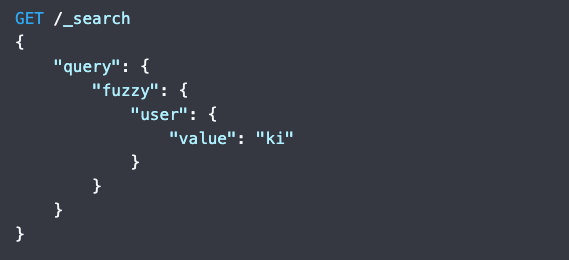

#### Consultas por filtros

In [ ]:
s = Search()
s = s.filter("term", tipo="PL")

eprint(s.execute())

In [ ]:
from datetime import datetime, timedelta, time

today = datetime.now().date()
last_year = today - timedelta(365)
today_end = datetime.combine(last_year, time())

s = Search()

s = s.filter('range', data={'gte': today_end, 'lte': today})

eprint(s.execute())

,tipo,ementa,data,topicos,clicks,id,score
0,SUG,Sugere estudo visando verificar a atuação do M...,2020-01-03T11:09:00,,8,2236217,0.0
1,SUG,Sugere audiência pública para debater assuntos...,2020-01-03T11:24:00,,0,2236218,0.0
2,RIC,Requer informações detalhadas ao Ministro da C...,2020-01-03T14:50:13,,4,2236222,0.0
3,MPV,Cria funções de confiança destinadas à Polícia...,2020-01-03T11:59:00,"Criação, Função Comissionada do Poder Executiv...",1,2236223,0.0
4,PRL,"Parecer do Relator, Dep. Eli Borges (SOLIDARI-...",2020-01-14T09:41:00,,5,2236230,0.0
5,PRL,"Parecer do Relator, Dep. Eli Borges (SOLIDARI-...",2020-01-14T09:42:00,,8,2236231,0.0
6,MSC,texto do Tratado entre a República Federativa ...,2020-01-17T11:17:00,,0,2236235,0.0
7,RIC,Solicita ao Ministério de Relações Exteriores ...,2020-01-22T15:53:32,,6,2236238,0.0
8,REQ,Solicita que seja convocado o Sr. Abraham Wein...,2020-01-24T09:54:00,,3,2236240,0.0
9,MSC,Texto do Protocolo sobre Transferência de Pess...,2020-01-24T12:58:00,,1,2236241,0.0




#### 5.   Consultas Aninhadas




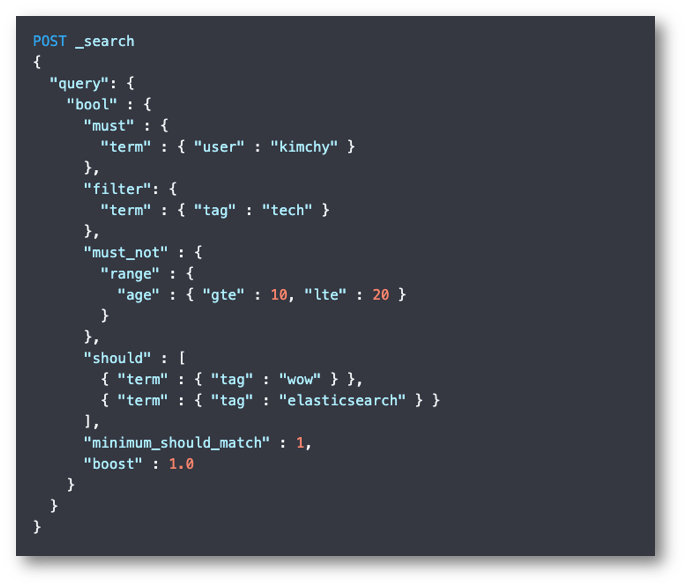

In [ ]:
from elasticsearch_dsl import Q

s = Search()

q = Q('bool',
    filter = [Q('term',tipo='PL')],
    must=[Q('match', ementa='saneamento basico'), Q('match', ementa='lei')],
    should=[Q('match', ementa='serviços'), Q('match', ementa='produto')],
    minimum_should_match=1
)


s = s.query(q)

jprint(s.to_dict())
eprint(s.execute())

{
  "query": {
    "bool": {
      "filter": [
        {
          "term": {
            "tipo": "PL"
          }
        }
      ],
      "must": [
        {
          "match": {
            "ementa": "saneamento basico"
          }
        },
        {
          "match": {
            "ementa": "lei"
          }
        }
      ],
      "should": [
        {
          "match": {
            "ementa": "serviços"
          }
        },
        {
          "match": {
            "ementa": "produto"
          }
        }
      ],
      "minimum_should_match": 1
    }
  }
}


,tipo,ementa,data,topicos,clicks,id,score
0,PL,"Altera a Lei nº 11.445, de 5 de janeiro de 200...",2020-03-30T19:22:00,"Alteração, Lei de Saneamento Básico, proibição...",4,2242387,14.212906
1,PL,"Altera a Lei no 11.445, de 5 de janeiro de 200...",2020-03-10T17:52:05,"Alteração, Lei de Saneamento Básico, obrigator...",1,2238670,10.630603
2,PL,"Altera os arts. 6º e 39 da Lei nº 8.078, de 11...",2020-03-26T14:00:00,"Alteração, Código de Defesa do Consumidor, Dir...",8,2242141,6.138413


#### Filtros de Agrupamentos

In [ ]:
s = Search()
s = s.query("match", ementa="saneamento básico")
s.aggs.bucket('tipos_terms', 'terms', field='tipo')

jprint(s.execute().to_dict()['aggregations'])

In [ ]:
s = Search()
s = s.query("match", ementa="saneamento básico")
s.aggs.metric('total_clicks', 'stats', field='clicks')

jprint(s.execute().to_dict()['aggregations'])

{
  "total_clicks": {
    "count": 141,
    "min": 0.0,
    "max": 9.0,
    "avg": 4.6453900709219855,
    "sum": 655.0
  }
}


#### Consultas avançadas

In [ ]:
# Ordenação
s = Search()
s = s.query("match", ementa="saneamento básico")
s = s.sort('data','-tipo')
eprint(s.execute())


,tipo,ementa,data,topicos,clicks,id,score
0,MSC,Acordo Básico de Cooperação Científica e Técni...,2020-01-31T17:46:00,,6,2236265,None
1,PDL,"Susta os efeitos do Decreto nº 10.216, de 30 d...",2020-02-05T14:58:00,"Sustação, Decreto, criação, Grupo de Trabalho ...",4,2236592,None
2,PL,"Altera a Lei nº 11.445, de 5 de janeiro de 200...",2020-02-06T11:51:27,"Alteração, Lei de Saneamento Básico, utilizaçã...",9,2236773,None
3,PL,Altera o art. 28 da Lei 9.394/1996 e estabelec...,2020-02-12T10:56:19,"Alteração, Lei de Diretrizes e Bases da Educaç...",3,2237018,None
4,INC,Sugere a inclusão de conhecimentos básicos sob...,2020-02-12T14:38:51,,7,2237040,None
5,REQ,Requer seja convocado o Senhor Abraham Weintra...,2020-02-14T15:06:00,,8,2237601,None
6,REQ,Requer a inclusão na Ordem do Dia da PEC 15/20...,2020-02-19T18:54:00,,3,2237951,None
7,MPV,"Altera a Lei nº 8.745, de 9 de dezembro de 199...",2020-03-02T09:45:00,"Alteração, Lei de Contratação Temporária de In...",8,2238102,None
8,INC,Sugere o lançamento de um programa específico ...,2020-03-05T14:59:05,,2,2238522,None
9,PL,"Institui a realização, em caráter anual, da ""S...",2020-03-05T15:03:00,"Criação, Semana de Valorização de Mulheres que...",8,2238527,None


In [ ]:
# Paginação
s = Search()
s = s.query("match", ementa="saneamento básico")

#Start and Limit
s = s[2:5]
eprint(s.execute())

,tipo,ementa,data,topicos,clicks,id,score
0,PL,"Altera a Lei nº 11.445, de 5 de janeiro de 20...",2020-07-01T10:57:00,"Alteração, Lei de Saneamento Básico, ampliação...",4,2256549,13.226944
1,RIC,Requer do Excelentíssimo Ministro do Meio Ambi...,2020-07-08T16:21:00,,3,2257039,12.472170
2,PDL,"Susta os efeitos do Decreto nº 10.216, de 30 d...",2020-02-05T14:58:00,"Sustação, Decreto, criação, Grupo de Trabalho ...",4,2236592,11.194571


In [ ]:
# Highlighting
s = Search()
s = s.query("match", ementa="saneamento básico")
s = s.highlight('ementa', fragment_size=10)

response = s.execute()

for hit in response:
    for fragment in hit.meta.highlight.ementa:
        print(fragment)
        print("")

nacionais para o <em>saneamento</em>

<em>básico</em>, para

planos de <em>saneamento</em>

<em>básico</em>.

específico para o <em>saneamento</em>

<em>básico</em> urbano

diretrizes para o <em>saneamento</em>

<em>básico</em>.

legal do <em>saneamento</em>

<em>básico</em>.

Nacional de <em>Saneamento</em>

<em>Básico</em>.

sistema de <em>Saneamento</em>

<em>Básico</em> e o

elétrica, gás, <em>saneamento</em>

<em>básico</em> e telecomunicações

tarifas de <em>saneamento</em>

<em>básico</em> e suspensão

condições <em>básicas</em>

empresas de <em>saneamento</em>

<em>básico</em>, com

elétrica e de <em>saneamento</em>

<em>básico</em> durante



Exemplos mais avançados de consultas https://github.com/elastic/elasticsearch-dsl-py/tree/master/examples

## Lab 3 Prático

Com conhecimento de busca no elasticsearch e com os documentos indexados no Lab 2, crie um buscador para os documentos do Lab 1. Exibir os 10 primeiros melhores resultados. Possibilitar a escolha de diferentes tipos de buscas.



In [ ]:
#@title Buscador de Artigos

buscador = '' #@param {type:"string"}
tipo_busca = 'palavras' #@param ["palavras", "frase", "booleana"]

print(buscador)